import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset_padding4cls import *
from utils.network_arch_cls import *
from utils.trainval_cls_withMasking import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [3]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'step009_clsGTMaskPadNoRejNoInd_P001_res34' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 100

#model parameters
batch_size = 8
newSize = [512, 512]
total_epoch_num = 300  # total number of epoch in training
base_lr = 0.0001      # base learning rate/


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

cuda:0


In [4]:
with open('dbinfo_cls_noReject_noInd.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)


cls_datasets = {set_name: PollenCls(dbinfo, size=newSize, set_name=set_name, maskType='grnd')
                for set_name in ['train', 'test']}


dataloaders = {set_name: DataLoader(cls_datasets[set_name],                                    
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'test']}

print(len(cls_datasets['train']), len(cls_datasets['test']))

28351 4027


In [5]:
data_sampler = iter(dataloaders['train'])

In [6]:
data = next(data_sampler)
image, segMask, label = data

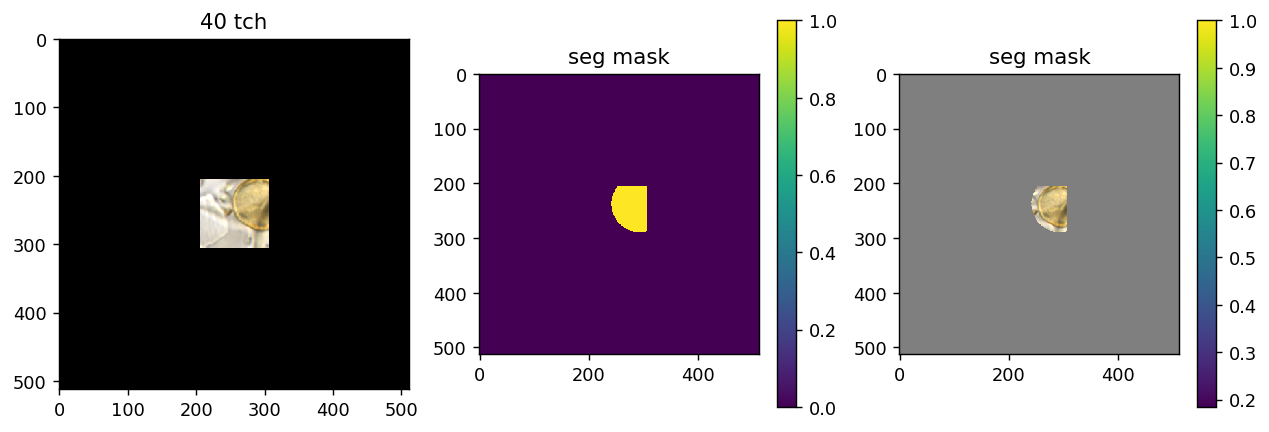

In [7]:
idx = 3
tmplabel = label[idx].squeeze().cpu().detach().numpy()
tmplabel = round(tmplabel.item())
labelName = dbinfo['meta'][tmplabel-1]


numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(12, 4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('{:02d} '.format(tmplabel)+labelName)


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = segMask[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx] * segMask[idx]
tmpImg = tmpImg.squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg mask')
plt.colorbar()

In [8]:
max(dbinfo['perClassCount']), min(dbinfo['perClassCount'])

(7006, 86)

Text(0, 0.5, 'number in train set')

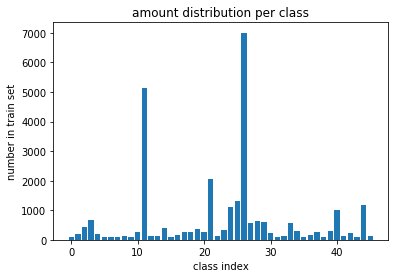

In [9]:
plt.bar(list(range(46)), dbinfo['perClassCount'])
plt.title('amount distribution per class')
plt.xlabel('class index')
plt.ylabel('number in train set')

In [10]:
################## init model ###################
initModel = PollenClsNet(34, nClass=46, pretrained=True, poolSize=16)
initModel.to(device);

using pretrained model


In [11]:
image = image.to(device)
label = label.type(torch.long).view(-1).to(device)
outputs = initModel(image)

In [12]:
lossFunc_cls = nn.CrossEntropyLoss()

#weight = torch.ones(2)
#weight[0] = 0.5
#weight = weight.to(device)
# lossFunc_seg = nn.CrossEntropyLoss(weight=weight, reduction='elementwise_mean')

In [13]:
image.shape, label.shape

(torch.Size([8, 3, 512, 512]), torch.Size([8]))

In [14]:
loss = lossFunc_cls(outputs, label.squeeze(-1).squeeze(-1))

In [15]:
optimizer = optim.Adam([{'params': initModel.parameters()}], 
                       lr=base_lr, weight_decay=0.0005) 

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=int(total_epoch_num/4), gamma=0.4)

In [16]:
################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

In [ ]:
model_ft = train_model(initModel, dataloaders, 
                       lossFunc_cls, optimizer, exp_lr_scheduler,                       
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, device=device, freqShow=freqShow)


Epoch 1/300
----------
train
	100/3544 loss:3.448
	200/3544 loss:3.150
	300/3544 loss:2.952
	400/3544 loss:2.840
	500/3544 loss:2.753
	600/3544 loss:2.691
	700/3544 loss:2.611
	800/3544 loss:2.555
	900/3544 loss:2.517




Leaving Blank
-----